In [1]:
import netCDF4 as nc
import numpy as np
from matplotlib import pylab as plt
import gsw
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import os
import numpy.ma as ma
import tools_for_croco as to

In [2]:
# Paramètres de la simulation
pathname='/home/brout/Documents/UBO/M2/GFD/projet/oman/'  # Path where all the different files are located. To extract
                                                                            # ncfiles, change their name with the pattern 'property.nc'


Re=6.4E6
dt=300             # 5 minutes
NWRT=288           # every 24 hours
Nz=32              # Number of vertical levels
dl=0.2             # resolution in degrees
delta_t=dt*NWRT
time_sample=5
lon_min,lon_max=55,63
lat_min,lat_max=17,24

#Section
lat_sect=21
lon_min_sect,lon_max_sect=58.5,60


In [3]:
def rho_to_zeta(grid):
    '''
    Linear interpolation of a rho grid on a zeta grid
    '''
    return(0.25*(grid[1:,1:]+grid[1:,:-1]+grid[:-1,1:]+grid[:-1,:-1]))

def u_to_zeta(grid):
    return(0.5*(grid[1:,:]+grid[:-1,:]))

def v_to_zeta(grid):
    return(0.5*(grid[:,1:]+grid[:,:-1]))

def rho_to_u(grid):
    return(0.5*(grid[:,1:]+grid[:,:-1]))

def rho_to_v(grid):
    return(0.5*(grid[1:,:]+grid[:-1,:]))

In [4]:
# Function to have ticks with mathematical coordinates, not computer ones
def tickstring_lon(x_ticks):
    tick=[]
    for i in range(len(x_ticks)):
        if x_ticks[i]<0 and x_ticks[i]%1==0:
            tick.append(str(abs(int(x_ticks[i])))+'°W')
        elif x_ticks[i]>0 and x_ticks[i]%1==0:
            tick.append(str(int(x_ticks[i]))+'°E')
        elif x_ticks[i]<0:
            tick.append(str(abs(x_ticks[i]))+'°W')
        elif x_ticks[i]>0:
            tick.append(str(abs(x_ticks[i]))+'°E')
        else:
            tick.append('0°')
    return(tick)

def tickstring_lat(y_ticks):
    tick=[]
    for i in range(len(y_ticks)):
        if y_ticks[i]<0 and y_ticks[i]%1==0:
            tick.append(str(abs(int(y_ticks[i])))+'°S')
        elif y_ticks[i]>0 and y_ticks[i]%1==0:
            tick.append(str(int(y_ticks[i]))+'°N')
        elif y_ticks[i]<0:
            tick.append(str(abs(y_ticks[i]))+'°S')
        elif y_ticks[i]>0:
            tick.append(str(abs(y_ticks[i]))+'°N')
        else:
            tick.append('0°')
    return(tick)

In [5]:
# to.zlevs is only for one particular level. this cell is to use it for more than one depth
def vinterp_multiple_depths(var3d,z,depths_array,topo=None,cubic=0):
    Nx,Ny=var3d.shape[2],var3d.shape[1]
    Nz=depths_array.shape[0]
    var_z=np.zeros((Nz,Ny,Nx))
    for i in range(Nz):
        var_z[i]=to.vinterp(var3d,z,depths_array[i],topo,cubic)
    return(var_z)

In [6]:
def U10(tau_x,tau_y):
    tau=np.sqrt(tau_x**2+tau_y**2)
    cos,sin=tau_x/tau,tau_y/tau
    U_10=np.sqrt(tau/(1.225e-3))
    u10,v10=U_10*cos,U_10*sin
    return(u10,v10)


In [7]:
# Importation des fichiers nc.

file=pathname+'croco_avg.nc'
avg=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')
avg.variables.keys()

odict_keys(['spherical', 'xl', 'el', 'xi_rho', 'xi_u', 'eta_rho', 'eta_v', 'Vtransform', 's_rho', 's_w', 'sc_r', 'sc_w', 'Cs_r', 'Cs_w', 'hc', 'h', 'f', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'angle', 'mask_rho', 'time_step', 'scrum_time', 'time', 'zeta', 'ubar', 'vbar', 'u', 'v', 'temp', 'salt', 'omega', 'w', 'bostr', 'wstr', 'sustr', 'svstr', 'AKt', 'hbl', 'hbbl', 'shflux', 'swflux', 'swrad'])

In [8]:
lon_rho=avg['lon_rho'][:]
lat_rho=avg['lat_rho'][:]
Ts=avg['temp'][:]

print(Ts.shape)

(24, 32, 39, 41)


31.942564


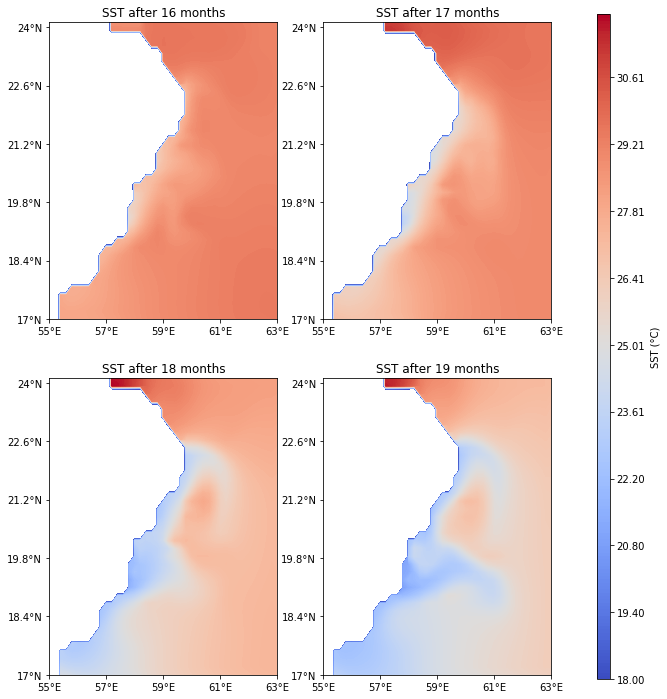

In [65]:
## Surface temperature plot
colormap='coolwarm' 
fig,((ax0,ax1),(ax2,ax3))=plt.subplots(2,2,figsize=(9,12))
time_indices=[16,17,18,19]
temp_max=np.max(abs(Ts))
temp_min=18
print(temp_max)
ticks_number_lon=5
ticks_number_lat=6


#ax0
#CS=ax0.contour(lon_rho,lat_rho,temp[time_indices[0],z],colors='k',linewidths=0.5,levels=25) # Change data input here
#plt.clabel(CS, fontsize=10, inline=True, fmt = '%0.1f')
mappable0=ax0.contourf(lon_rho,lat_rho,Ts[time_indices[0],-1],levels=np.linspace(temp_min,temp_max,200),cmap=colormap,vmax=temp_max,vmin=temp_min)  # Change data input here
ax0.set_title(r'SST after '+str(time_indices[0])+' months')

# Set ticks
plt.sca(ax0)
x_ticks=np.linspace(lon_min,lon_max,ticks_number_lon)
x_strings=tickstring_lon(x_ticks)
plt.xticks(x_ticks,x_strings)
y_ticks=np.linspace(lat_min,lat_max,ticks_number_lat)
y_strings=tickstring_lat(y_ticks)
plt.yticks(y_ticks,y_strings)



#ax1
#CS=ax1.contour(lon_rho,lat_rho,temp[time_indices[1],z],colors='k',linewidths=0.5,levels=25) # Change data input here
#plt.clabel(CS, fontsize=10, inline=True, fmt = '%0.1f')
mappable1=ax1.contourf(lon_rho,lat_rho,Ts[time_indices[1],-1],levels=np.linspace(temp_min,temp_max,200),cmap=colormap,vmax=temp_max,vmin=temp_min)  # Change data input here
ax1.set_title(r'SST after '+str(time_indices[1])+' months')

# Set ticks
plt.sca(ax1)
x_ticks=np.linspace(lon_min,lon_max,ticks_number_lon)
x_strings=tickstring_lon(x_ticks)
plt.xticks(x_ticks,x_strings)
y_ticks=np.linspace(lat_min,lat_max,ticks_number_lat)
y_strings=tickstring_lat(y_ticks)
plt.yticks(y_ticks,y_strings)

#ax2
#CS=ax2.contour(lon_rho,lat_rho,temp[time_indices[2],z],colors='k',linewidths=0.5,levels=25) # Change data input here
#plt.clabel(CS, fontsize=10, inline=True, fmt = '%0.1f')
mappable2=ax2.contourf(lon_rho,lat_rho,Ts[time_indices[2],-1],levels=np.linspace(temp_min,temp_max,200),cmap=colormap)  # Change data input her
ax2.set_title(r'SST after '+str(time_indices[2])+' months')

# Set ticks
plt.sca(ax2)
x_ticks=np.linspace(lon_min,lon_max,ticks_number_lon)
x_strings=tickstring_lon(x_ticks)
plt.xticks(x_ticks,x_strings)
y_ticks=np.linspace(lat_min,lat_max,ticks_number_lat)
y_strings=tickstring_lat(y_ticks)
plt.yticks(y_ticks,y_strings)


#ax3
#CS=ax3.contour(lon_rho,lat_rho,temp[time_indices[3],z],colors='k',linewidths=0.5,levels=25) # Change data input here
#plt.clabel(CS, fontsize=10, inline=True, fmt = '%0.1f')
mappable3=ax3.contourf(lon_rho,lat_rho,Ts[time_indices[3],-1],levels=np.linspace(temp_min,temp_max,200),cmap=colormap,vmax=temp_max,vmin=temp_min)  # Change data input here

ax3.set_title(r'SST after '+str(time_indices[3])+' months')

# Set ticks
plt.sca(ax3)
x_ticks=np.linspace(lon_min,lon_max,ticks_number_lon)
x_strings=tickstring_lon(x_ticks)
plt.xticks(x_ticks,x_strings)
y_ticks=np.linspace(lat_min,lat_max,ticks_number_lat)
y_strings=tickstring_lat(y_ticks)
plt.yticks(y_ticks,y_strings)


wi,hi  = 0.02,0.77                                             # Colorbar dimensions
xc,yc  = 0.97,0.12                                             # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable1,cax,orientation='vertical')
cb.set_label('SST (°C)',fontsize=10,labelpad=5)

#plt.savefig(pathname+'fig/SST')

In [9]:
# Other simulation
lonmin2,lonmax2=58,61
latmin2,latmax2=19,22

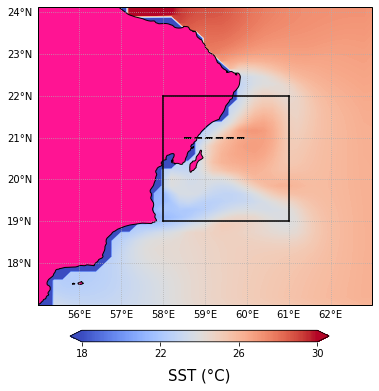

In [71]:
# Plot of the eddy kinetic energy over the last 12 months
# Plot of velocities with map
colormap='coolwarm'
temp_max=30
temp_min=18
proj=ccrs.PlateCarree()
#features
land_10m=cfeature.NaturalEarthFeature(category='physical',
                            name='land',
                            scale='10m',
                            edgecolor='k',
                            facecolor='deeppink')

fig,ax0=plt.subplots(figsize=(6,8))
#plt.subplots_adjust(left = 0.1, right = 0.75, top = 1, bottom = 0.0)
ax0=plt.axes(projection=proj)
gl0=ax0.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl0.xlabels_top = False
gl0.ylabels_right = False
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
gl0.xlabel_style = {'size': 10, 'color': 'black'}
gl0.ylabel_style = {'size': 10, 'color': 'black'}


#adding features
ax0.add_feature(land_10m)
#adding the velocity vector
mappable=ax0.contourf(lon_rho,lat_rho,Ts[19,-1,:,:],cmap=colormap,levels=np.linspace(temp_min,temp_max,200),extend='both')
plt.hlines(lat_sect,lon_min_sect,lon_max_sect,linewidth=2,linestyle='dashed')

# Domain of the other simulation
ax0.plot([lonmin2,lonmax2],[latmin2,latmin2],c='k')
ax0.plot([lonmin2,lonmax2],[latmax2,latmax2],c='k')
ax0.plot([lonmin2,lonmin2],[latmin2,latmax2],c='k')
ax0.plot([lonmax2,lonmax2],[latmin2,latmax2],c='k')


#Colorbar
wi,hi  = 0.6,0.02                                               # Colorbar dimensions
xc,yc  = 0.2,0.18                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable,cax,orientation='horizontal',extend='both')
cb.set_label(r'SST (°C)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(temp_min,temp_max,4))
plt.savefig('SST_august')


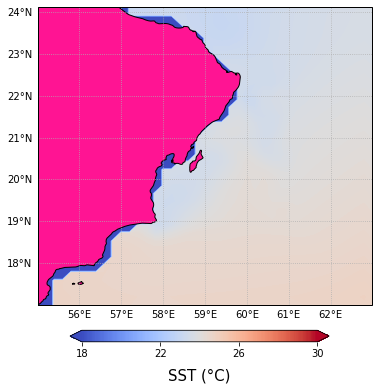

In [56]:
# Plot of the eddy kinetic energy over the last 12 months
# Plot of velocities with map
colormap='coolwarm'
temp_max=30
temp_min=18
proj=ccrs.PlateCarree()
#features
land_10m=cfeature.NaturalEarthFeature(category='physical',
                            name='land',
                            scale='10m',
                            edgecolor='k',
                            facecolor='deeppink')

fig,ax=plt.subplots(figsize=(6,8))
#plt.subplots_adjust(left = 0.1, right = 0.75, top = 1, bottom = 0.0)
ax=plt.axes(projection=proj)
gl1=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 10, 'color': 'black'}
gl1.ylabel_style = {'size': 10, 'color': 'black'}


#adding features
ax.add_feature(land_10m)
#adding the velocity vector
mappable=ax.contourf(lon_rho,lat_rho,Ts[13,-1,:,:],cmap=colormap,levels=np.linspace(temp_min,temp_max,200),extend='both')

#Colorbar
#Colorbar
wi,hi  = 0.6,0.02                                               # Colorbar dimensions
xc,yc  = 0.2,0.18                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable,cax,orientation='horizontal',extend='both')
cb.set_label(r'SST (°C)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(temp_min,temp_max,4))
plt.savefig('SST_february')


# Wind forcing

In [55]:
# Importation des fichiers nc.

file=pathname+'croco_avg.nc'
avg=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')
avg.variables.keys()

odict_keys(['spherical', 'xl', 'el', 'xi_rho', 'xi_u', 'eta_rho', 'eta_v', 'Vtransform', 's_rho', 's_w', 'sc_r', 'sc_w', 'Cs_r', 'Cs_w', 'hc', 'h', 'f', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'angle', 'mask_rho', 'time_step', 'scrum_time', 'time', 'zeta', 'ubar', 'vbar', 'u', 'v', 'temp', 'salt', 'omega', 'w', 'bostr', 'wstr', 'sustr', 'svstr', 'AKt', 'hbl', 'hbbl', 'shflux', 'swflux', 'swrad'])

In [72]:
lon_rho=avg['lon_rho'][:]
lat_rho=avg['lat_rho'][:]
tau_x0,tau_y0=avg['sustr'][:],avg['svstr'][:]
time_index=19
tau_x=0.5*(tau_x0[:,1:,:]+tau_x0[:,:-1,:])[time_index]
tau_y=0.5*(tau_y0[:,:,1:]+tau_y0[:,:,:-1])[time_index]
u10,v10=U10(tau_x,tau_y)



#put everything on the zeta grid
lon_zeta=rho_to_zeta(lon_rho)
lat_zeta=rho_to_zeta(lat_rho)
U=np.sqrt(u10**2+v10**2)

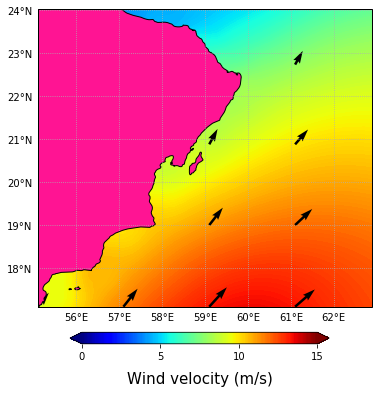

In [73]:
# Plot of the eddy kinetic energy over the last 12 months
# Plot of velocities with map

vmin,vmax=0,15
colormap='jet'
proj=ccrs.PlateCarree()
#features
land_10m=cfeature.NaturalEarthFeature(category='physical',
                            name='land',
                            scale='10m',
                            edgecolor='k',
                            facecolor='deeppink')

fig,ax=plt.subplots(figsize=(6,8))
#plt.subplots_adjust(left = 0.1, right = 0.75, top = 1, bottom = 0.0)
ax=plt.axes(projection=proj)
gl1=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 10, 'color': 'black'}
gl1.ylabel_style = {'size': 10, 'color': 'black'}


#adding features
ax.add_feature(land_10m)
#adding the velocity vector
mappable=ax.contourf(lon_zeta,lat_zeta,U,cmap=colormap,levels=np.linspace(vmin,vmax,200),extend='both')
ax.quiver(lon_zeta[::10,::10],lat_zeta[::10,::10],u10[::10,::10],v10[::10,::10])
#Colorbar
wi,hi  = 0.6,0.02                                               # Colorbar dimensions
xc,yc  = 0.2,0.18                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable,cax,orientation='horizontal',extend='both')
cb.set_label(r'Wind velocity (m/s)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(vmin,vmax,4))
#cb.set_tick
#cb.ax.tick_params(labelsize=10)
plt.savefig('wind_august')


In [74]:
lon_rho=avg['lon_rho'][:]
lat_rho=avg['lat_rho'][:]
tau_x0,tau_y0=avg['sustr'][:],avg['svstr'][:]
time_index=13
tau_x=0.5*(tau_x0[:,1:,:]+tau_x0[:,:-1,:])[time_index]
tau_y=0.5*(tau_y0[:,:,1:]+tau_y0[:,:,:-1])[time_index]
u10,v10=U10(tau_x,tau_y)



#put everything on the zeta grid
lon_zeta=rho_to_zeta(lon_rho)
lat_zeta=rho_to_zeta(lat_rho)
U=np.sqrt(u10**2+v10**2)

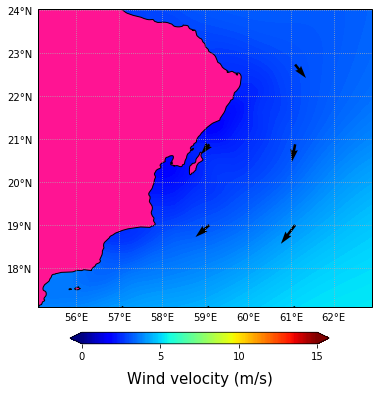

In [75]:
# Plot of the eddy kinetic energy over the last 12 months
# Plot of velocities with map
time_index=13
vmin,vmax=0,15
colormap='jet'
proj=ccrs.PlateCarree()
#features
land_10m=cfeature.NaturalEarthFeature(category='physical',
                            name='land',
                            scale='10m',
                            edgecolor='k',
                            facecolor='deeppink')

fig,ax=plt.subplots(figsize=(6,8))
#plt.subplots_adjust(left = 0.1, right = 0.75, top = 1, bottom = 0.0)
ax=plt.axes(projection=proj)
gl1=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 10, 'color': 'black'}
gl1.ylabel_style = {'size': 10, 'color': 'black'}


#adding features
ax.add_feature(land_10m)
#adding the velocity vector
mappable=ax.contourf(lon_zeta,lat_zeta,U,cmap=colormap,levels=np.linspace(vmin,vmax,200),extend='both')
ax.quiver(lon_zeta[::10,::10],lat_zeta[::10,::10],u10[::10,::10],v10[::10,::10])
#Colorbar
wi,hi  = 0.6,0.02                                               # Colorbar dimensions
xc,yc  = 0.2,0.18                                                # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable,cax,orientation='horizontal',extend='both')
cb.set_label(r'Wind velocity (m/s)',fontsize=15,labelpad=10)
cb.set_ticks(np.linspace(vmin,vmax,4))
#cb.set_tick
#cb.ax.tick_params(labelsize=10)
plt.savefig('wind_february')


In [16]:
# Importation des fichiers nc.

file=pathname+'oman_HR_his.nc'
his=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')
his.variables.keys()

odict_keys(['spherical', 'xl', 'el', 'xi_rho', 'xi_u', 'eta_rho', 'eta_v', 'Vtransform', 's_rho', 's_w', 'sc_r', 'sc_w', 'Cs_r', 'Cs_w', 'hc', 'h', 'f', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'angle', 'mask_rho', 'time_step', 'scrum_time', 'time', 'zeta', 'ubar', 'vbar', 'u', 'v', 'temp', 'salt', 'w', 'bostr', 'wstr', 'sustr', 'svstr', 'AKt', 'hbl', 'hbbl', 'shflux', 'swflux', 'swrad'])

In [17]:
time_sample=5
us=his['u'][::time_sample,-1,:,:]
vs=his['v'][::time_sample,-1,:,:]
lon_u,lat_u=his['lon_u'][:],his['lat_u'][:]
lon_v,lat_v=his['lon_v'][:],his['lat_v'][:]
time=his['time'][::time_sample]

us_zeta=0.5*(us[:,1:,:]+us[:,:-1,:])
vs_zeta=0.5*(vs[:,:,1:]+vs[:,:,:-1])
dx=(lon_v[:,1:]-lon_v[:,:-1])*np.pi/180*Re*np.cos(lat_v[:,:-1]*np.pi/180)
dy=(lat_u[1:,:]-lat_u[:-1,:])*Re*np.pi/180
print(np.max(dx))
KEs=0.5*(us_zeta**2+vs_zeta**2)
print(KEs.shape)

#Surface kinetic energy integrated over the domain
SKE=np.sum(KEs*dx,axis=2)
SKE=np.sum(SKE*dy[:,0],axis=1)

7039.99
(147, 49, 45)


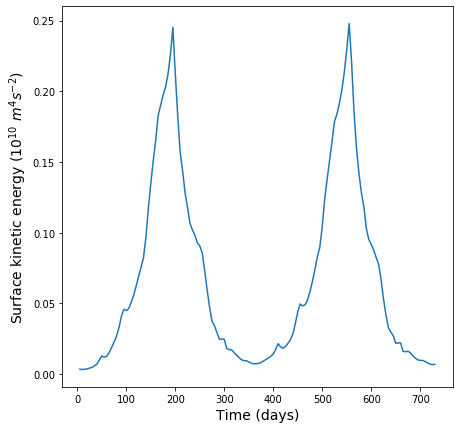

In [18]:
# Kinetic energy
fig,ax=plt.subplots(figsize=(7,7))
ax.plot(time[1:]/3600/24,SKE[1:]*1e-10)
ax.set_xlabel('Time (days)',fontsize=14)
ax.set_ylabel(r'Surface kinetic energy ($10^{10}\ m^4s^{-2}$)',fontsize=14)
plt.savefig('KE_SMALL')

# SECTIONS

In [12]:
# Importation des fichiers nc.

file=pathname+'oman_HR_avg.nc'
avg=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')
avg.variables.keys()

odict_keys(['spherical', 'xl', 'el', 'xi_rho', 'xi_u', 'eta_rho', 'eta_v', 'Vtransform', 's_rho', 's_w', 'sc_r', 'sc_w', 'Cs_r', 'Cs_w', 'hc', 'h', 'f', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'angle', 'mask_rho', 'time_step', 'scrum_time', 'time', 'zeta', 'ubar', 'vbar', 'u', 'v', 'temp', 'salt', 'omega', 'w', 'bostr', 'wstr', 'sustr', 'svstr', 'AKt', 'hbl', 'hbbl', 'shflux', 'swflux', 'swrad'])

In [13]:
time_indices=[13,19]

In [19]:
lon_rho,lat_rho=avg['lon_rho'][0],avg['lat_rho'][:,0]
eta=avg['zeta']
SA_sigma=avg['salt'][:]
pt_sigma=avg['temp'][:]
print(SA_sigma.shape)

(24, 32, 50, 46)


In [15]:
# Find the y-index where the latitude is equal to lat_sect
lat_index=np.where(abs(lat_rho-lat_sect)<(dl/2))[0][0]

# Find the index of lon_v where the longitude is between lon_min and lon_max
lon_min_index=np.min(np.where(lon_rho>lon_min_sect))-1
lon_max_index=np.max(np.where(lon_rho<lon_max_sect))+2
lon_sect=lon_rho[lon_min_index:lon_max_index]
print(lon_sect) 

[58.466667 58.533333 58.6      58.666668 58.733334 58.8      58.866665
 58.933334 59.       59.066666 59.133335 59.2      59.266666 59.333332
 59.4      59.466667 59.533333 59.6      59.666668 59.733334 59.8
 59.866665 59.933334 60.      ]


In [18]:
%%time
hc = avg.hc
Cs_r = avg.Cs_r
Cs_w = avg.Cs_w
depth=-np.linspace(0,300,100)

topo=avg.variables['h'][:] # on the rho grid


#Compute vertical coordinates 
(z_r0,z_w0) =  to.zlevs(topo,eta[time_indices[0]], hc, Cs_r, Cs_w)
(z_r1,z_w1) =  to.zlevs(topo,eta[time_indices[1]], hc, Cs_r, Cs_w)



SA_z0 = vinterp_multiple_depths(SA_sigma[time_indices[0]],z_r0,depth,topo=topo,cubic=1)
SA_z1 = vinterp_multiple_depths(SA_sigma[time_indices[1]],z_r0,depth,topo=topo,cubic=1)
pt_z0 = vinterp_multiple_depths(pt_sigma[time_indices[0]],z_r0,depth,topo=topo,cubic=1)
pt_z1 = vinterp_multiple_depths(pt_sigma[time_indices[1]],z_r0,depth,topo=topo,cubic=1)


# Sections
SA0_sect=SA_z0[:,lat_index,lon_min_index:lon_max_index]
SA1_sect=SA_z1[:,lat_index,lon_min_index:lon_max_index]
pt0_sect=pt_z0[:,lat_index,lon_min_index:lon_max_index]
pt1_sect=pt_z1[:,lat_index,lon_min_index:lon_max_index]
for i in range(SA0_sect.shape[0]):
    for j in range(SA0_sect.shape[1]):
        if SA0_sect[i,j]==0.0:
            SA0_sect[i,j]=float('NaN') 
            SA1_sect[i,j]=float('NaN')
            pt0_sect[i,j]=float('NaN')
            pt1_sect[i,j]=float('NaN')

# Compute pressure (in dbar) from depth
p=gsw.p_from_z(depth,lat_sect)
p2=np.zeros_like(SA0_sect)
for i in range(SA0_sect.shape[1]):
    p2[:,i]=p


# Compute density in z coordinates
density0_sect = gsw.rho(SA0_sect,pt0_sect,p2)
density1_sect = gsw.rho(SA1_sect,pt1_sect,p2)

CPU times: user 2.24 s, sys: 8.95 ms, total: 2.25 s
Wall time: 2.29 s


(100, 24)


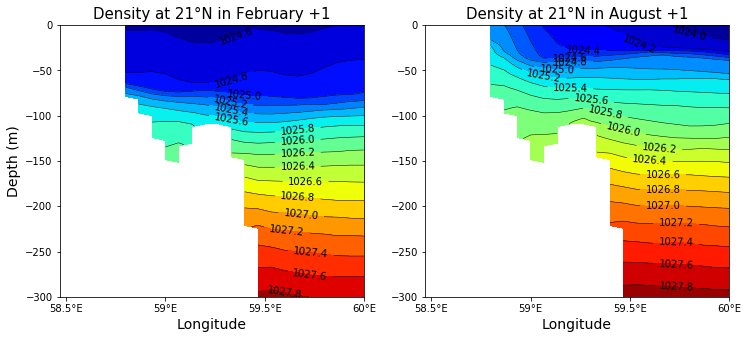

In [55]:
colormap='jet'                        # Choisir une colormap pour le plot


LS,D=np.meshgrid(lon_sect,depth)       # Grille pour tracer les contours de température conservative
print(LS.shape)
fig,(ax0,ax1)=plt.subplots(1,2,figsize=(12,5))     
grandeur='Density'       # String for the title of the plot
unit=r'(kg/m$^3$)'                            # Unit of the physical scale plotted
ticks_number=4

# Set title
if lat_sect<0:                     # In the original array, western longitudes are negative, eastern longitudes are positive
    card='S'
elif lat_sect>0:
    card='N'
else:
    card=''
title0=grandeur + ' at ' + str(abs(lat_sect)) + '°' + card+ ' in February +1'
title1=grandeur + ' at ' + str(abs(lat_sect)) + '°' + card+ ' in August +1'



# t = 90 days
CS0=ax0.contour(LS,D,density0_sect,colors='k',linewidths=0.5,levels=20) # Change data input here
plt.clabel(CS0, fontsize=10, inline=True, fmt = '%0.1f')                  
mappable=ax0.contourf(LS,D,density0_sect,levels=20,cmap=colormap)      # Change data input here
ax0.set_xlabel('Longitude',fontsize=14)
ax0.set_ylabel(r'Depth (m)',fontsize=14)
ax0.set_title(title0,fontsize=15)


# Set ticks
x_ticks=np.linspace(lon_min_sect,lon_max_sect,ticks_number)
x_strings=tickstring_lon(x_ticks)
plt.sca(ax0)
plt.xticks(x_ticks,x_strings)


# t = 360 days
CS1=ax1.contour(LS,D,density1_sect,colors='k',linewidths=0.5,levels=20) # Change data input here
plt.clabel(CS1, fontsize=10, inline=True, fmt = '%0.1f')                  
mappable=ax1.contourf(LS,D,density1_sect,levels=20,cmap=colormap)      # Change data input here
ax1.set_xlabel('Longitude',fontsize=14)
#ax1.set_ylabel(r'Depth (m)',fontsize=14)
ax1.set_title(title1,fontsize=15)


# Set ticks
x_ticks=np.linspace(lon_min_sect,lon_max_sect,ticks_number)
x_strings=tickstring_lon(x_ticks)
plt.sca(ax1)
plt.xticks(x_ticks,x_strings)




plt.savefig('density_section')

# Small domain section